In [1]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from frag_tools import (EquipmentScaler,
                        TargetBinarizer,
                        NameChanger,
                        MakeDummies,
                        DropColumns)

# Notes

This notebook contains initial data cleaning and some minor exploration. It's a tad unorganized as I tried to encapsulate all of my cleaning into a pipeline using the raw data.

I ultimately decided to drop all columns that could qualify as time-series with exception of hours since failure. I'll perform a separate time series analysis to see if this is worth exploring.

In [4]:
raw_df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/bigml_5acff779eba31d156f0000fa.csv')

In [69]:
pipe = Pipeline([
('name_changer', NameChanger()),
('scaler', EquipmentScaler(scaled_cols)),
('get_dummies', MakeDummies(['Operator', 'day-of-week'])),
('scale_y', TargetBinarizer('failure')),
('drop_cols', DropColumns(['date', 'year', 'month', 'day-of-month', 'hour', 'minute', 'second',
                         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                         'Saturday', 'Sunday']))
])

In [73]:
pipe.fit_transform(raw_df);

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
scaled_cols = ['temp', 'humidity']
scaled_cols.extend([f'Measure{i}' for i in range(1, 16)])
scaled_cols.append('hours_since_prev_fail')

In [64]:
name_changer = NameChanger()
scaler = EquipmentScaler(scaled_cols)
dummies = MakeDummies(['Operator', 'day-of-week'])
scaled_y = TargetBinarizer('failure')
drop_cols = DropColumns(['date', 'year', 'month', 'day-of-month', 'hour', 'minute', 'second',
                         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                         'Saturday', 'Sunday'])

In [65]:
changed = name_changer.fit_transform(raw_df)
scaled_vals = scaler.fit_transform(changed)
dummied = dummies.fit_transform(scaled_vals)
y_done = scaled_y.fit_transform(dummied)
final_all = drop_cols.fit_transform(y_done)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
raw_df['Failure'].value_counts()

No     8703
Yes      81
Name: Failure, dtype: int64

In [51]:
raw_df['Operator'].value_counts()

Operator2    1952
Operator1     976
Operator4     976
Operator5     976
Operator8     976
Operator3     976
Operator7     976
Operator6     976
Name: Operator, dtype: int64

In [12]:
raw_df.columns

Index(['Date', 'Temperature', 'Humidity', 'Operator', 'Measure1', 'Measure2',
       'Measure3', 'Measure4', 'Measure5', 'Measure6', 'Measure7', 'Measure8',
       'Measure9', 'Measure10', 'Measure11', 'Measure12', 'Measure13',
       'Measure14', 'Measure15', 'Hours Since Previous Failure', 'Failure',
       '﻿Date.year', '﻿Date.month', '﻿Date.day-of-month', '﻿Date.day-of-week',
       '﻿Date.hour', '﻿Date.minute', '﻿Date.second'],
      dtype='object')

Fifteen columns have generic names. In the spirit of creativity, I renamed these columns to readings that we may actually see on equipment logs, though their values may be unrealistic to what we could expect of these readings. 

In [13]:
raw_df[[f'Measure{i}' for i in range(1, 16)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 15 columns):
Measure1     8784 non-null int64
Measure2     8784 non-null int64
Measure3     8784 non-null int64
Measure4     8784 non-null int64
Measure5     8784 non-null int64
Measure6     8784 non-null int64
Measure7     8784 non-null int64
Measure8     8784 non-null int64
Measure9     8784 non-null int64
Measure10    8784 non-null int64
Measure11    8784 non-null int64
Measure12    8784 non-null int64
Measure13    8784 non-null int64
Measure14    8784 non-null int64
Measure15    8784 non-null int64
dtypes: int64(15)
memory usage: 1.0 MB


In [15]:
replacements = {key: value for key, value in zip([f'Measure{i}' for i in range(1, 16)], fake_categories)}
new_columns = [name if name not in replacements else replacements[name] for name in raw_df.columns]

There are some odd strings in the 'Date.' categories. I'll clean those up.

In [17]:
new_columns[-7:] = ['year', 'month', 'day-of-month', 'day-of-week', 'hour', 'minute', 'second']

In [18]:
raw_df.columns = new_columns

Next, change the 'Date' column datatype to datetime objects.

In [19]:
raw_df['Date'] = pd.to_datetime(raw_df['Date'])

In [20]:
one_hot = LabelBinarizer()
binary_labels = one_hot.fit_transform(raw_df['Failure'].values)

In [21]:
raw_df['Failure'] = binary_labels

In [22]:
raw_df.Operator.value_counts()

Operator2    1952
Operator1     976
Operator4     976
Operator5     976
Operator8     976
Operator3     976
Operator7     976
Operator6     976
Name: Operator, dtype: int64

In [56]:
operator_dummies = pd.get_dummies(raw_df, columns=['Operator'])

In [24]:
equipment_df = pd.concat([raw_df.drop('Operator', axis=1), operator_dummies], axis=1)

In [25]:
equipment_df = equipment_df.drop(['minute', 'second'], axis=1)

In [26]:
equipment_df.head()

,Date,Temperature,Humidity,discharge_pressure,suction_pressure,differential_pressure,rotor_temperature,packing_leakage_rate,axial_bearing_temp,horizontal_bearing_temp,...,day-of-week,hour,Operator1,Operator2,Operator3,Operator4,Operator5,Operator6,Operator7,Operator8
0,2016-01-01 00:00:00,67,82,291,1,1,1041,846,334,706,...,5,0,1,0,0,0,0,0,0,0
1,2016-01-01 01:00:00,68,77,1180,1,1,1915,1194,637,1093,...,5,1,1,0,0,0,0,0,0,0
2,2016-01-01 02:00:00,64,76,1406,1,1,511,1577,1121,1948,...,5,2,1,0,0,0,0,0,0,0
3,2016-01-01 03:00:00,63,80,550,1,1,1754,1834,1413,1151,...,5,3,1,0,0,0,0,0,0,0
4,2016-01-01 04:00:00,65,81,1928,1,2,1326,1082,233,1441,...,5,4,1,0,0,0,0,0,0,0


In [27]:
week_dummies = pd.get_dummies(equipment_df['day-of-week'])

In [29]:
equipment_df = pd.concat([equipment_df.drop('day-of-week', axis=1), week_dummies], axis=1)

In [30]:
equipment_df.head()

,Date,Temperature,Humidity,discharge_pressure,suction_pressure,differential_pressure,rotor_temperature,packing_leakage_rate,axial_bearing_temp,horizontal_bearing_temp,...,Operator6,Operator7,Operator8,1,2,3,4,5,6,7
0,2016-01-01 00:00:00,67,82,291,1,1,1041,846,334,706,...,0,0,0,0,0,0,0,1,0,0
1,2016-01-01 01:00:00,68,77,1180,1,1,1915,1194,637,1093,...,0,0,0,0,0,0,0,1,0,0
2,2016-01-01 02:00:00,64,76,1406,1,1,511,1577,1121,1948,...,0,0,0,0,0,0,0,1,0,0
3,2016-01-01 03:00:00,63,80,550,1,1,1754,1834,1413,1151,...,0,0,0,0,0,0,0,1,0,0
4,2016-01-01 04:00:00,65,81,1928,1,2,1326,1082,233,1441,...,0,0,0,0,0,0,0,1,0,0


In [31]:
column_list = list(equipment_df.columns)

In [32]:
column_list[-7:] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [33]:
column_list[1:3] = ['ambient_temp', 'ambient_humidity']

In [34]:
equipment_df.columns = column_list

In [35]:
equipment_df.head()

,Date,ambient_temp,ambient_humidity,discharge_pressure,suction_pressure,differential_pressure,rotor_temperature,packing_leakage_rate,axial_bearing_temp,horizontal_bearing_temp,...,Operator6,Operator7,Operator8,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2016-01-01 00:00:00,67,82,291,1,1,1041,846,334,706,...,0,0,0,0,0,0,0,1,0,0
1,2016-01-01 01:00:00,68,77,1180,1,1,1915,1194,637,1093,...,0,0,0,0,0,0,0,1,0,0
2,2016-01-01 02:00:00,64,76,1406,1,1,511,1577,1121,1948,...,0,0,0,0,0,0,0,1,0,0
3,2016-01-01 03:00:00,63,80,550,1,1,1754,1834,1413,1151,...,0,0,0,0,0,0,0,1,0,0
4,2016-01-01 04:00:00,65,81,1928,1,2,1326,1082,233,1441,...,0,0,0,0,0,0,0,1,0,0


In [36]:
hour_dummie_headers = [f'hour_{i}' for i in range(0, 24)]

In [37]:
hour_dummies = pd.get_dummies(equipment_df['hour'])

In [38]:
adapted_equipment_df = pd.concat([equipment_df, hour_dummies], axis=1)

In [39]:
adapted_equipment_df.head()

,Date,ambient_temp,ambient_humidity,discharge_pressure,suction_pressure,differential_pressure,rotor_temperature,packing_leakage_rate,axial_bearing_temp,horizontal_bearing_temp,...,14,15,16,17,18,19,20,21,22,23
0,2016-01-01 00:00:00,67,82,291,1,1,1041,846,334,706,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-01 01:00:00,68,77,1180,1,1,1915,1194,637,1093,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-01 02:00:00,64,76,1406,1,1,511,1577,1121,1948,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-01 03:00:00,63,80,550,1,1,1754,1834,1413,1151,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-01 04:00:00,65,81,1928,1,2,1326,1082,233,1441,...,0,0,0,0,0,0,0,0,0,0


In [40]:
hour_columns = list(adapted_equipment_df.columns)
hour_columns[-24:] = hour_dummie_headers
adapted_equipment_df.columns = hour_columns

In [41]:
adapted_equipment_df.columns

Index(['Date', 'ambient_temp', 'ambient_humidity', 'discharge_pressure',
       'suction_pressure', 'differential_pressure', 'rotor_temperature',
       'packing_leakage_rate', 'axial_bearing_temp', 'horizontal_bearing_temp',
       'frequency', 'noise', 'voltage', 'current', 'speed', 'system_pressure',
       'suction_fluid_temperature', 'discharge_fluid_temperature',
       'Hours Since Previous Failure', 'Failure', 'year', 'month',
       'day-of-month', 'hour', 'Operator1', 'Operator2', 'Operator3',
       'Operator4', 'Operator5', 'Operator6', 'Operator7', 'Operator8',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [42]:
final = adapted_equipment_df.drop('Date', axis=1)

In [43]:
final.head()

,ambient_temp,ambient_humidity,discharge_pressure,suction_pressure,differential_pressure,rotor_temperature,packing_leakage_rate,axial_bearing_temp,horizontal_bearing_temp,frequency,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,67,82,291,1,1,1041,846,334,706,1086,...,0,0,0,0,0,0,0,0,0,0
1,68,77,1180,1,1,1915,1194,637,1093,524,...,0,0,0,0,0,0,0,0,0,0
2,64,76,1406,1,1,511,1577,1121,1948,1882,...,0,0,0,0,0,0,0,0,0,0
3,63,80,550,1,1,1754,1834,1413,1151,945,...,0,0,0,0,0,0,0,0,0,0
4,65,81,1928,1,2,1326,1082,233,1441,1736,...,0,0,0,0,0,0,0,0,0,0


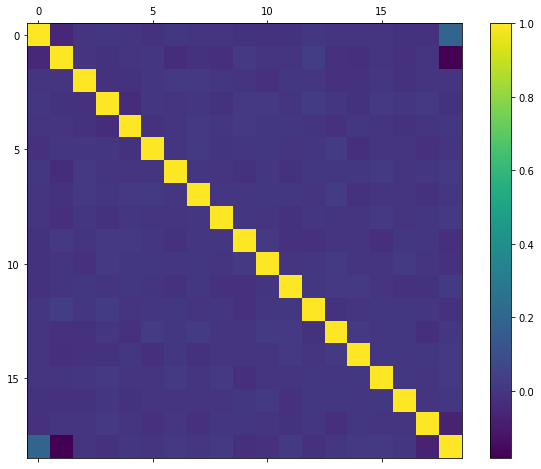

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
matrix = ax.matshow(final.iloc[:, :19].corr())
fig.colorbar(matrix);

In [45]:
sans_labels = final.drop(['Failure', 'year', 'month', 'day-of-month', 'hour'], axis=1)

In [46]:
sans_labels.loc[:1, 'ambient_temp': 'Hours Since Previous Failure']

,ambient_temp,ambient_humidity,discharge_pressure,suction_pressure,differential_pressure,rotor_temperature,packing_leakage_rate,axial_bearing_temp,horizontal_bearing_temp,frequency,noise,voltage,current,speed,system_pressure,suction_fluid_temperature,discharge_fluid_temperature,Hours Since Previous Failure
0,67,82,291,1,1,1041,846,334,706,1086,256,1295,766,968,1185,1355,1842,90
1,68,77,1180,1,1,1915,1194,637,1093,524,919,245,403,723,1446,719,748,91


In [66]:
final_all.columns

Index(['temp', 'humidity', 'Measure1', 'Measure2', 'Measure3', 'Measure4',
       'Measure5', 'Measure6', 'Measure7', 'Measure8', 'Measure9', 'Measure10',
       'Measure11', 'Measure12', 'Measure13', 'Measure14', 'Measure15',
       'hours_since_prev_fail', 'failure', 'Operator1', 'Operator2',
       'Operator3', 'Operator4', 'Operator5', 'Operator6', 'Operator7',
       'Operator8'],
      dtype='object')

In [71]:
EquipmentScaler(['ambient_temp', 'ambient_humidity', 'discharge_pressure', 'suction_pressure','differential_pressure','rotor_temperature', 'packing_leakage_rate', 'axial_bearing_temp', 'horizontal_bearing_temp','frequency', 'noise', 'voltage', 'current', 'speed', 'system_pressure','suction_fluid_temperature', 'discharge_fluid_temperature', 'Hours Since Previous Failure']).fit_transform(sans_labels.copy());

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
